# Market Segmentation for a French (C2C) Fashion Store

Market segmentation for a french (C2C) fashion store using cluster analysis to achieve more effective customer marketing via personalization.     

The goal of the project is to find out a ratio of types of customers who are sellers to support decision making in customer marketing.    

The data source is 'data.world' portal https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store.    

The focus of the project is customers who are active users of the platform in selling field. To be consider as an active user, they should have at least one sold product.

### Importing packages, loading the data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import collections

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn import cluster, tree, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Disable zero division warnings
np.errstate(divide='ignore')

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
fontsize=16     # Font size of a  figure title

# Download the dataset
# Source https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
fl = '2. Prepared Data/6M-0K-99K.users.dataset.public.csv'
data = pd.read_csv(fl)

# Preview data
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9006282053848196165,user,Suède,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2858299215060733023,user,France,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr


## 1. Data Preprocessing

### 1.1. Exploratory Data Analysis & Data Cleaning

In [2]:
# Get base information on the dataset
data.columns

Index(['identifierHash', 'type', 'country', 'language', 'socialNbFollowers',
       'socialNbFollows', 'socialProductsLiked', 'productsListed',
       'productsSold', 'productsPassRate', 'productsWished', 'productsBought',
       'gender', 'civilityGenderId', 'civilityTitle', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'seniorityAsMonths', 'seniorityAsYears', 'countryCode'],
      dtype='object')

In [3]:
# Drop columns with information that will not be used or is duplicated 
drop_columns = ['civilityGenderId', 'civilityTitle', 'seniorityAsMonths', 'seniorityAsYears','countryCode']
data.drop(columns=drop_columns, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  hasAnyApp            98913 non-null  bool   
 14  hasAndroidApp        98913 non-null  bool   
 15  hasIosApp            98913 non-null 

In [4]:
# Get the dimensionality of the dataset
print(data.shape)

(98913, 19)


In [5]:
# Check that user identification numbers are unique
users = len(data['identifierHash'].unique().tolist())
print(f'Duplicated users: {users-data.shape[0]}')

# Chech type of users is 'user' 
user_types = (data['type']=='user').sum() - data.shape[0]

# Drop 'type' column if type of all users is 'user' 
if user_types==0:
    data.drop(columns='type', inplace=True)
    
# Drop rows if type of users is different from 'user'
# Then drop 'type' column
else:
    other_types = data['type']!='user'
    data.drop(data[other_types].index, inplace=True)
    data.drop(columns='type', inplace=True)

Duplicated users: 0


In [6]:
# Check duplicated rows
print(f'Duplicated rows : {data.duplicated().sum()}')
# Find missing values 
print(f'Missing values: {data.isnull().sum().sum()}')

Duplicated rows : 0
Missing values: 0


In [7]:
# Filter data of active users, who has sold products

###################################### FILTER ################################################

# List of columns related to user activity in selling of products
#products = ['socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought']
#products = ['productsSold', 'productsListed']
products = ['productsSold']
# Calculate sum across rows
data['productSum'] = data[products].sum(axis=1)

# Filter data of user who have any activity (sum > 0)
data = data[data['productSum'] > 0]
###################################### END FILTER ################################################

# Drop utility 'productSum' column
data.drop(columns=['productSum', 'identifierHash'], inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

# Preview data
data.head()

,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority
0,France,fr,31,8,0,1,1,0.0,0,1,F,True,False,True,False,127,3205
1,France,fr,7,8,6,1,1,0.0,0,0,F,True,False,True,True,485,3205
2,Royaume-Uni,en,10,8,0,0,3,66.0,0,0,F,True,False,True,True,665,3205
3,France,fr,3,8,0,0,1,0.0,0,0,M,False,False,False,True,405,3205
4,Royaume-Uni,en,16,0,6,0,1,0.0,303,32,M,True,True,False,False,20,3205


In [8]:
# Get the dimensionality of the dataset
print(data.shape)

(2036, 17)


In [9]:
# Get statistics for numeric columns
data.describe() 

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniority
count,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000
mean,11.848723,24.544204,70.349705,3.973477,5.907171,39.463310,18.294204,2.439096,190.700393,3063.709234
std,24.246375,367.788293,1183.479716,13.663211,13.626529,44.563032,108.396766,13.971495,226.993545,168.489727
min,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.000000,2852.000000
25%,4.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,14.000000,2857.000000
50%,6.000000,8.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,58.500000,3196.000000
75%,11.000000,9.000000,12.000000,3.000000,5.000000,91.000000,2.000000,1.000000,346.000000,3201.000000
max,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,1916.000000,405.000000,709.000000,3205.000000


In [10]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numeric_cols = data.select_dtypes([np.int64,np.float64]).columns.tolist()
print (f'Numeric: {len(numeric_cols)} \n{numeric_cols}')

categorical_cols = data.select_dtypes([np.object]).columns.tolist()
print (f'Categorical: {len(categorical_cols)} \n{categorical_cols}')

booleans_cols = data.select_dtypes([np.bool]).columns.tolist()
print (f'Boolean: {len(booleans_cols)} \n{booleans_cols}')

Columns
Numeric: 10 
['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority']
Categorical: 3 
['country', 'language', 'gender']
Boolean: 4 
['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture']


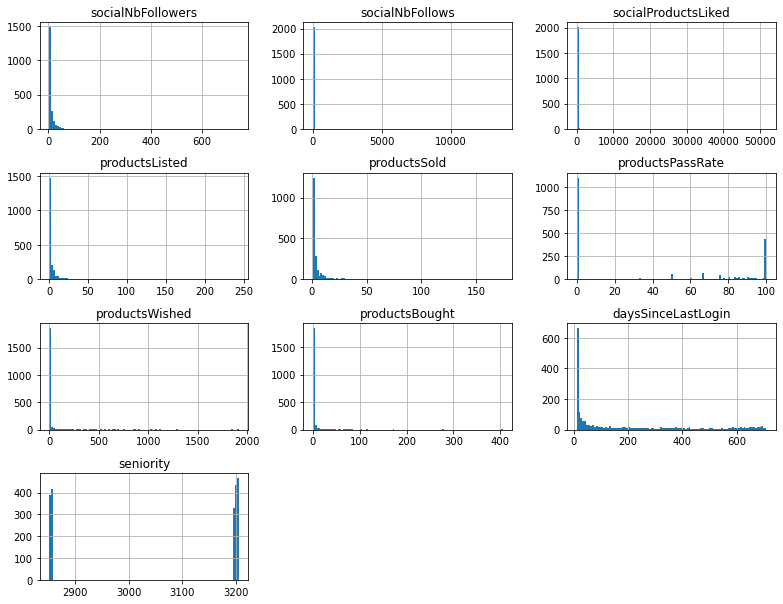

In [11]:
# Plot the distribution of numerical columns

# Create list of numerical columns for plots
# Copy the list of numerical columns
numeric_cols_plot = numeric_cols.copy()

# Plot histograms
data[numeric_cols_plot].hist(figsize=(11,8.5), bins=100)
plt.tight_layout()


 	 Percentage of zero values
'socialNbFollowers':  0 - 0.0%
'socialNbFollows':  14 - 0.69%
'socialProductsLiked':  795 - 39.05%
'productsWished':  1300 - 63.85%
'productsBought':  1474 - 72.4%
'productsSold':  0 - 0.0%
'productsListed':  995 - 48.87%

 	 Percentage of values in (0,10] interval
'socialNbFollowers':  1478 - 72.59%
'socialNbFollows':  1798 - 88.31%
'socialProductsLiked':  691 - 33.94%
'productsWished':  471 - 23.13%
'productsBought':  467 - 22.94%
'productsSold':  1781 - 87.48%
'productsListed':  875 - 42.98%


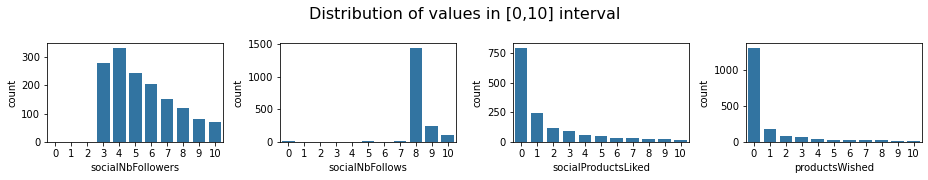

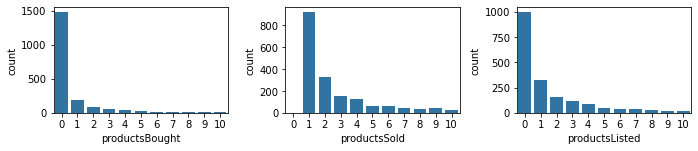

In [12]:
# Plot the distribution of numerical columns in [0,10] interval
num_columns_1 = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsWished'] 
num_columns_2 = ['productsBought','productsSold', 'productsListed']
rows=len(data)

n=10

fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,2.5))
fig.suptitle(f'Distribution of values in [0,{n}] interval', fontsize=fontsize)
for index,col in enumerate(num_columns_1):
    sns.countplot(x=data[data[col]<= n][col], ax=axes[index], order=range(0,11), color=color)
plt.tight_layout()

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9.8,2.2))
for index,col in enumerate(num_columns_2):
    sns.countplot(x=data[data[col]<= n][col], ax=axes[index], order=range(0,11), color=color)
plt.tight_layout()

m=0

num_columns_list = num_columns_1 + num_columns_2
print('\n \t Percentage of zero values')
for index,col in enumerate(num_columns_list):
    number_values = len(data[data[col] == m][col])
    percent_values = round(number_values/rows*100,2)
    print(f"'{col}':  {number_values} - {percent_values}%")
    
print(f'\n \t Percentage of values in (0,{n}] interval')
for index,col in enumerate(num_columns_list):
    number_values = len(data[(data[col] > m) & (data[col] <= n)][col])
    percent_values = round(number_values/rows*100,2)
    print(f"'{col}':  {number_values} - {percent_values}%")


 	 Number of values greater than 100
'socialNbFollowers':  19
'socialNbFollows':  17
'socialProductsLiked':  142
'productsWished':  83
'productsBought':  5
'productsSold':  9
'productsListed':  10


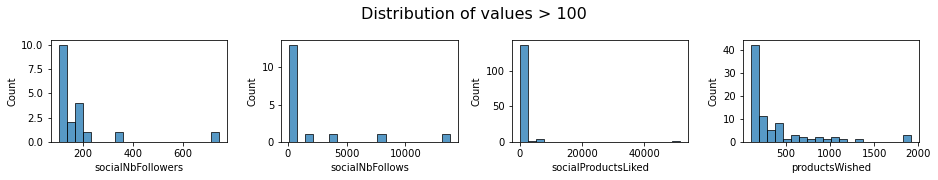

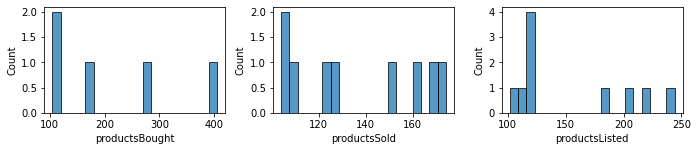

In [13]:
# Plot the distribution of numerical columns in [100, ) interval


fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,2.5))
fig.suptitle('Distribution of values > 100', fontsize=fontsize)
for index,col in enumerate(num_columns_1):
    sns.histplot(x=data[data[col]>100][col], ax=axes[index], bins=20, color=color)
plt.tight_layout()

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9.8,2.2))
for index,col in enumerate(num_columns_2):
    sns.histplot(x=data[data[col]>100][col], ax=axes[index], bins=20, color=color)
plt.tight_layout()

print('\n \t Number of values greater than 100')
for index,col in enumerate(num_columns_list):
    print(f"'{col}':  {len(data[data[col]>100][col])}")

Text(0.5, 1.0, 'Correlation Matrix')

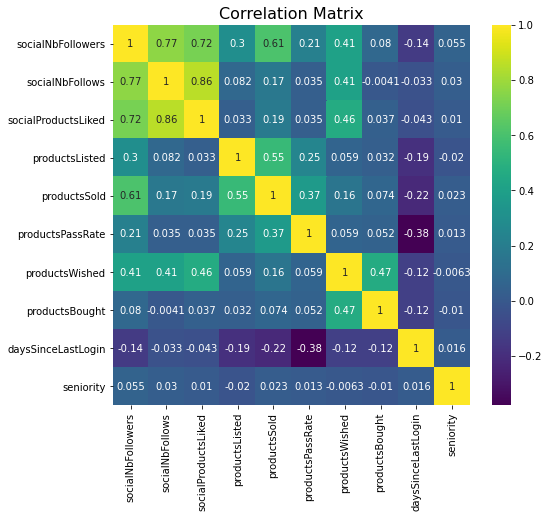

In [14]:
# Generate our corelation plot or heatmap
corr = data[numeric_cols_plot].corr()
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(corr,annot=True,cmap='viridis')
plt.title('Correlation Matrix', fontsize=fontsize) 

Text(0.5, 1.0, "Correlation of the numeric features to the 'productsSold' column")

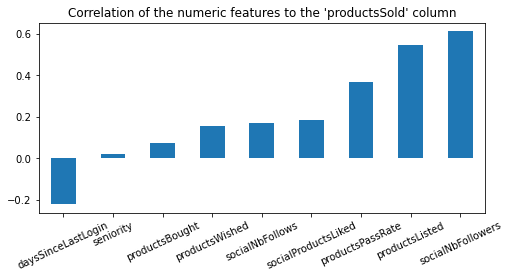

In [15]:
fig, ax = plt.subplots(figsize=(8,3.5))
ax = corr['productsSold'].sort_values().drop('productsSold').plot(kind='bar')
ax.xaxis.set_tick_params(rotation=25)
plt.title("Correlation of the numeric features to the 'productsSold' column")

Text(0.5, 1.0, "Correlation of the numeric features to the 'productsBought' column")

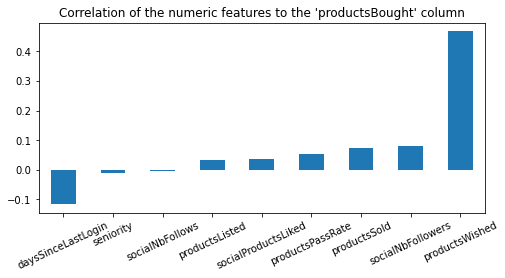

In [16]:
fig, ax = plt.subplots(figsize=(8,3.5))
ax = corr['productsBought'].sort_values().drop('productsBought').plot(kind='bar')
ax.xaxis.set_tick_params(rotation=25)
plt.title("Correlation of the numeric features to the 'productsBought' column")

In [17]:
# Generate pairplot
#sns.pairplot(data[numeric_cols_plot].drop(['daysSinceLastLogin','seniority'], axis=1))

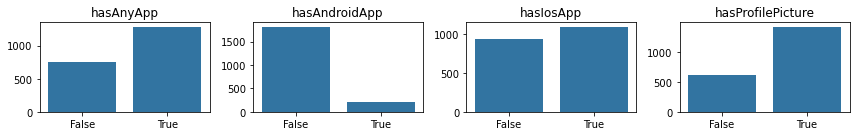

In [18]:
# Plot booleans data
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2))
for index, column in enumerate(booleans_cols):
    ax=sns.countplot(x=data[column],orient='h', ax=axes[index], color=color)
    ax.set_title(data[column].name)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

In [19]:
# Plot categorical data
# Count number of countries
countries_number = len(data['country'].unique().tolist())
print(f'Countries: {countries_number}')

# Translate the list of countries into English 
data['country'] = data['country'].replace({
     'Royaume-Uni':'UK', 'Danemark':'Denmark','Etats-Unis':'US', 'Allemagne':'Germany', 
     'Suisse':'Swiss','Suède':'Sweden','Australie':'Australia','Italie':'Italy', 'Espagne':'Spain', 
     'Finlande':'Finland','Belgique':'Belgium','Pays-Bas':'Netherlands', 'Autriche':'Austria', 
    'Russie':'Russia', 'Bulgarie':'Bulgaria', 'Chine':'China', 'Irlande': 'Ireland', 'Roumanie':'Romania'})

# Group users by country
countries=pd.DataFrame(data['country'].value_counts()).sort_values(by='country',ascending=False)
countries.rename(columns={'country':'users'}, inplace=True)
# Calculate % of total users by country
countries['users_%_total'] = round(countries['users']/countries['users'].sum(),3)*100

# Number of users by country
users_20 = countries.head(20)
users_20

Countries: 42


,users,users_%_total
France,713,35.0
Italy,347,17.0
UK,289,14.2
US,150,7.4
Spain,119,5.8
Germany,105,5.2
Netherlands,54,2.7
Belgium,35,1.7
Sweden,32,1.6
Denmark,22,1.1


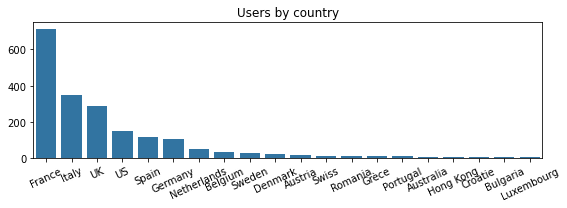

In [20]:
# Plot categorical data
fig, ax1 = plt.subplots(figsize=(8,3))

sns.barplot(x=users_20.index, y=users_20['users'], color=color, ax=ax1)

ax1.set_title('Users by country')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.xaxis.set_tick_params(rotation=25)

plt.tight_layout()

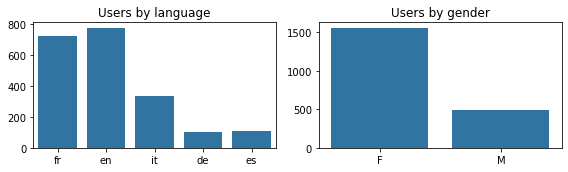

In [21]:
# Plot categorical data
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(8,2.5))

sns.countplot(x=data['language'],orient='h', color=color, ax=ax1)
sns.countplot(x=data['gender'],orient='h', color=color, ax=ax2)

ax1.set_title('Users by language')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_title('Users by gender')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()

In [22]:
# Selling by country
selling_filter = (data['productsListed']==0) & (data['productsSold']==0)
selling_data = data[~selling_filter]
selling_data_group=selling_data.groupby('country')[['productsSold', 'productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).reset_index()
selling_data_group['%sold']=round(selling_data_group[('productsSold', 'sum')]/selling_data_group[('productsSold', 'sum')].sum(),3)*100
selling_data_group['%listed']=round(selling_data_group[('productsListed', 'sum')]/selling_data_group[('productsListed', 'sum')].sum(),3)*100
selling_top10=selling_data_group.nlargest(10,('productsSold', 'sum'))
# Start the index from 1
selling_top10.index=selling_top10.index+1
print('Sold products by top 10 countries')
selling_top10

Sold products by top 10 countries


,country,productsSold,productsListed,%sold,%listed
,,sum,sum,,
1,France,3014,1892,25.1,23.4
2,Italy,2820,2218,23.4,27.4
3,UK,1806,927,15.0,11.5
4,Spain,990,594,8.2,7.3
5,US,967,816,8.0,10.1
6,Germany,536,264,4.5,3.3
7,Sweden,336,231,2.8,2.9
8,Netherlands,214,139,1.8,1.7
9,Monaco,190,26,1.6,0.3


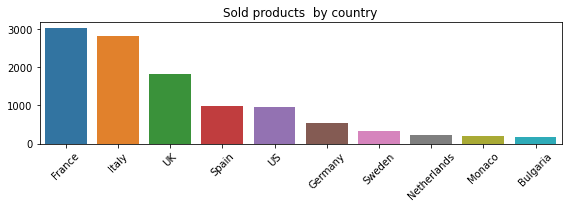

In [23]:
fig, ax = plt.subplots(figsize=(8,3))
ax=sns.barplot(x=selling_top10['country'],y=selling_top10[('productsSold', 'sum')])
ax.set_title('Sold products  by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [24]:
# Verification Selling
#data.groupby('country')[[ 'productsSold','productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).T

In [25]:
# Buying by country
buying_filter = (data['socialProductsLiked']==0) & (data['productsWished']==0) & (data['productsBought']==0)
buying_data = data[~buying_filter]
buying_data_group=buying_data.groupby('country')[['productsBought','socialProductsLiked', 'productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).reset_index()
buying_data_group['%bought']=round(buying_data_group[('productsBought', 'sum')]/buying_data_group[('productsBought', 'sum')].sum(),3)*100
buying_data_group['%liked']=round(buying_data_group[('socialProductsLiked', 'sum')]/buying_data_group[('socialProductsLiked', 'sum')].sum(),3)*100
buying_data_group['%wished']=round(buying_data_group[('productsWished', 'sum')]/buying_data_group[('productsWished', 'sum')].sum(),3)*100
buying_top10=buying_data_group.nlargest(10,('productsBought', 'sum'))
# Start the index from 1
buying_top10.index=buying_top10.index+1
print('Bought products by top 10 countries')
buying_top10

Bought products by top 10 countries


,country,productsBought,socialProductsLiked,productsWished,%bought,%liked,%wished
,,sum,sum,sum,,,
1,France,1187,19316,4974,23.9,13.5,13.4
2,US,548,5317,1384,11.0,3.7,3.7
3,UK,490,6157,3096,9.9,4.3,8.3
4,Belgium,447,732,2118,9.0,0.5,5.7
5,Italy,375,63125,6773,7.6,44.1,18.2
6,Spain,374,13661,4324,7.5,9.5,11.6
7,Germany,331,4606,3675,6.7,3.2,9.9
8,Netherlands,198,2506,896,4.0,1.7,2.4
9,Sweden,157,9161,1961,3.2,6.4,5.3


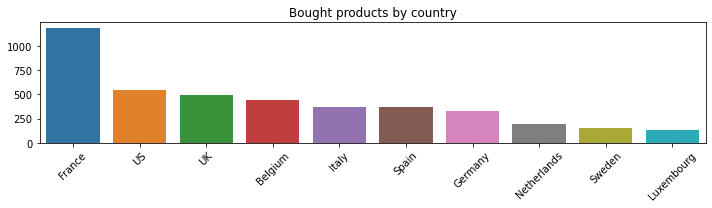

In [26]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=buying_top10['country'],y=buying_top10[('productsBought', 'sum')])
ax.set_title('Bought products by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [27]:
# Verification Buying
#data.groupby('country')[['productsBought','socialProductsLiked','productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).T

### 1.2. Data preprocessing, Feature Engineering

In [28]:
# Define countries as 'Other', if % of users is less then 1%
users_perc_lim = 1
other_countries = countries[countries['users_%_total']<users_perc_lim].index.tolist()
print(f'Other countries: {len(other_countries)}')
#print(other_countries)
data['country_short_list']=data['country'].apply(lambda x: 'Other' if x in other_countries else x)
countries_list = data['country_short_list'].unique().tolist()
print(f'Countries short list: {countries_list}')

Other countries: 32
Countries short list: ['France', 'UK', 'Other', 'Netherlands', 'Germany', 'Italy', 'Sweden', 'US', 'Spain', 'Denmark', 'Belgium']


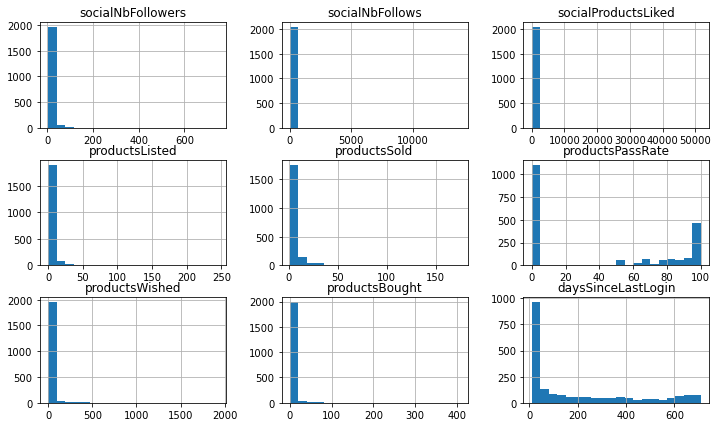

In [29]:
# Remove the 'identifierHash' column
numeric_cols_plot.remove('seniority')

# Plot a histogram of numeric columns
data[numeric_cols_plot].hist(figsize=(12,7), bins =20)
plt.show()

In [30]:
filter_outliers = (data['socialNbFollows']>5000) | (data['socialNbFollowers']>500) | (data['socialProductsLiked']>10000)
data[filter_outliers]

,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,country_short_list
747,France,fr,353,8268,5595,5,15,66.0,875,0,F,True,False,True,False,31,3198,France
989,Italy,it,744,13764,51671,0,104,85.0,1842,0,F,True,False,True,False,14,3195,Italy


In [31]:
# Drop extreme outliers
data.drop(data[filter_outliers].index, inplace=True)

# Save the outliers to a csv file
file = '4. Analysis/droped_outliers_classification_e-commerce_clusters.csv'
data.to_csv(file, index = False)
print(data.shape)

(2034, 18)


In [32]:
data['social']= data['socialNbFollowers'] + data['socialNbFollows'] 
data['products'] = data['socialProductsLiked'] + data['productsWished']

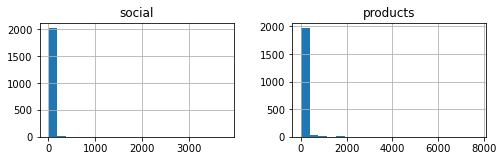

In [33]:
# Plot a histogram of numeric columns
data[['social','products']].hist(figsize=(8,2.1), bins =20)
plt.show()

In [34]:
# Save the initial data to use with results of clustering
data_origin = data.copy()
data_origin.head()

,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,country_short_list,social,products
0,France,fr,31,8,0,1,1,0.0,0,1,F,True,False,True,False,127,3205,France,39,0
1,France,fr,7,8,6,1,1,0.0,0,0,F,True,False,True,True,485,3205,France,15,6
2,UK,en,10,8,0,0,3,66.0,0,0,F,True,False,True,True,665,3205,UK,18,0
3,France,fr,3,8,0,0,1,0.0,0,0,M,False,False,False,True,405,3205,France,11,0
4,UK,en,16,0,6,0,1,0.0,303,32,M,True,True,False,False,20,3205,UK,16,309


In [35]:
# Transform predictor variables using Yeo-Johnson transformation
columns = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 
           'productsSold', 'productsWished', 'productsBought', 'daysSinceLastLogin','social', 'products', 
           'productsPassRate', 'seniority']

qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
data[columns] = qt.fit_transform(data[columns])

Numeric columns: ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority', 'social', 'products']


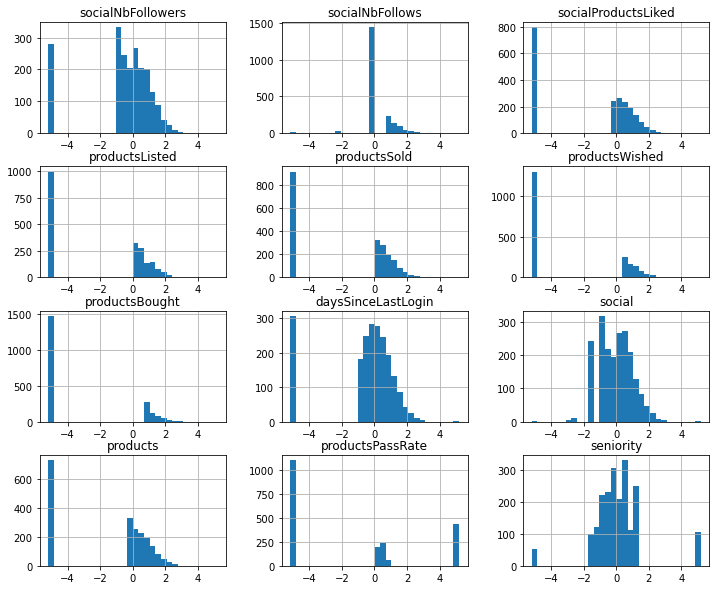

In [36]:
numeric_cols=data.select_dtypes(include=[np.number]).columns.to_list()
print(f'Numeric columns: {numeric_cols}')
# Plot a histogram of numeric columns
data[columns].hist(figsize=(12,10), bins =30)
plt.show()

In [37]:
# Change the boolean column type to integer
data[booleans_cols]=data[booleans_cols].astype(int)

# Duplicate columns
data['language_c']=data['language']
# Convert categorical variable into dummy/indicator variables
cat_features =['language', 'gender', 'country_short_list']
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

# Rename columns
data.rename(columns={'language_c': 'language'}, inplace=True)

# Check that 'hasAnyApp' is 'hasAndroidApp' or 'hasIosApp'
(data['hasAndroidApp']+data['hasIosApp']-data['hasAnyApp']).isnull().sum()

0

In [38]:
# Save the preprocessed data to a csv file
file = '2. Prepared Data/classification_e-commerce_preprocessed_data.csv'
data.to_csv(file, index = False)
data.shape 

(2034, 33)

In [39]:
def get_model_parameters(model_name, results_list):
    """ Returns a list of patameters that is relevant to the highest silhoette score. """
    # Initiate a dictionary to save a silhoette score and index from the list of parameters
    coeff = {}
    # Loop through the list of parameters
    for index,result in enumerate(results_list):
        # Save index and silhoette coefficient to the list
        coeff.update({result[0] : index})
    
    # Find out the highest silhoette coefficient
    max_coeff = max(coeff.keys())
    
    # Find out the List of patameters that is relevant to the best score
    results = results_list[coeff.get(max_coeff)]
            
    # Return the list of patameters that is relevant to the highest silhoette score
    return results

def print_model_parameters(model_name, results_list):
    """ Prints model's name and parameters in form: '# [Silhoette Coefficient, eps, min_smpl, n_clusters]'. """
    print(model_name)
    print(f'# [Silhoette Coefficient, eps, min_smpl, n_clusters]')
    
    for index,result in enumerate(results_list):
        print(index, result)
    
def print_model_n_clusters_parameter(model_name, results_list):
    """ Prints model's name and a n_clusters parameter in form: '# [Silhoette Coefficient, n_clusters]'. """
    print(model_name)
    print(f'# [Silhoette Coefficient, n_clusters]')
    
    for index,result in enumerate(results_list):
        print(index, result)

## 2. Clustering

### 2.1. Features 

In [40]:
data.columns

Index(['country', 'socialNbFollowers', 'socialNbFollows',
       'socialProductsLiked', 'productsListed', 'productsSold',
       'productsPassRate', 'productsWished', 'productsBought', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'social', 'products', 'language', 'language_en',
       'language_es', 'language_fr', 'language_it', 'gender_M',
       'country_short_list_Denmark', 'country_short_list_France',
       'country_short_list_Germany', 'country_short_list_Italy',
       'country_short_list_Netherlands', 'country_short_list_Other',
       'country_short_list_Spain', 'country_short_list_Sweden',
       'country_short_list_UK', 'country_short_list_US'],
      dtype='object')

In [41]:
# Select features
features = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold',
       'productsPassRate', 'productsWished', 'productsBought', 'social', 'products'        
        #'daysSinceLastLogin',
        ]
print(f'Features: \n {features}')

Features: 
 ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'social', 'products']


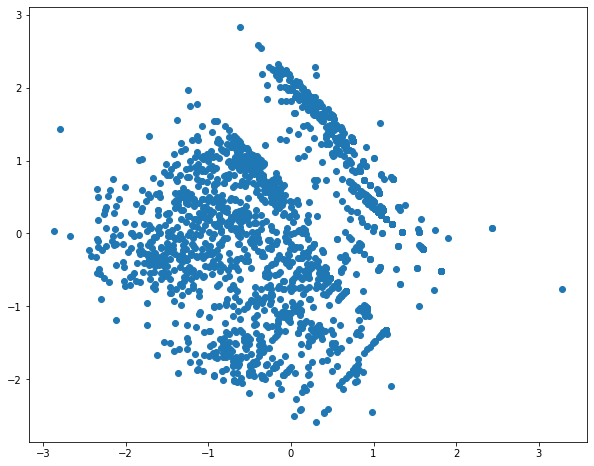

In [42]:
# Set up the data
df_scl=data[features].copy()

# Scale the data 
df_scl[features] = StandardScaler().fit_transform(df_scl)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl[features])

df_scl['x']=df_pca[:,0]
df_scl['y']=df_pca[:,1]

#plt.figure(figsize=(8,6))
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

In [43]:
df_scl[features].describe()

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,social,products
count,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03,2.034000e+03
mean,-6.899321e-17,-1.323098e-16,8.351235e-17,-2.218263e-16,3.613410e-17,-4.803325e-17,1.330739e-16,-1.257598e-16,6.069656e-17,3.720393e-16
std,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00,1.000246e+00
min,-2.324333e+00,-5.861384e+00,-1.228283e+00,-1.011926e+00,-1.089891e+00,-8.505132e-01,-7.467292e-01,-6.151152e-01,-5.291790e+00,-1.310222e+00
25%,-1.403259e-01,-4.076469e-01,-1.228283e+00,-1.011926e+00,-1.089891e+00,-8.505132e-01,-7.467292e-01,-6.151152e-01,-8.453499e-01,-1.310222e+00
50%,2.076751e-01,-4.076469e-01,5.266292e-01,7.643891e-01,6.783199e-01,-8.505132e-01,-7.467292e-01,-6.151152e-01,5.399891e-02,5.225680e-01
75%,5.621713e-01,8.367742e-01,7.986769e-01,9.352847e-01,8.915892e-01,5.341639e-01,1.195895e+00,1.447116e+00,6.389735e-01,7.635682e-01
max,2.811698e+00,5.772377e+00,2.366857e+00,2.428811e+00,2.394302e+00,1.597543e+00,2.700666e+00,2.995085e+00,5.272126e+00,2.366014e+00


### 2.2. Base Model

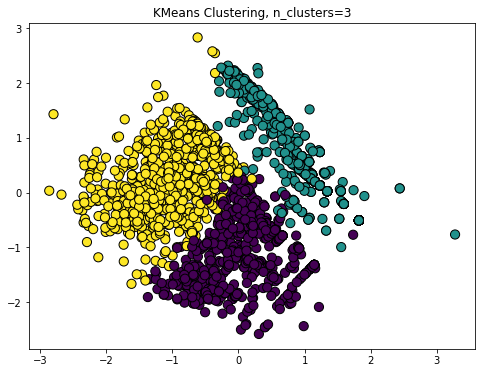

KMeans Clustering:
n_clusters=3, Silhouette Coefficient: 0.25583972360316554
Clusters: Counter({1: 730, 2: 720, 0: 584})


In [44]:
# Set up the data
df = data[features].copy()

# Scale the data 
#df_scl = MinMaxScaler().fit_transform(df)
df_scl = StandardScaler().fit_transform(df)


# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

# ---------------------------------- KMeans Clustering ------------------------------------------
# A number of clusters
n_clusters=3
# KMeans model
km = KMeans(n_clusters=n_clusters, max_iter=500, random_state=None).fit(df_scl)
labels = km.labels_

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering, n_clusters={n_clusters}')
plt.show()

print('KMeans Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(df_scl, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

In [45]:
print('Base Model:')
print(km)

Base Model:
KMeans(max_iter=500, n_clusters=3)


### 2.3. Model Selection

In [46]:
# Set up the data
df = data[features].copy()

# Scale the data 
df_scl = StandardScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- KMeans Clustering ------------------------------------------
model_name = 'KMeans'

# Initiate a list of results
results_list = []

# Loop through the range of a number of clusters
clusters = range(2, 11)
for index, n_cluster in enumerate(clusters):
    # Fit a model
    kmeans = KMeans(n_clusters=n_cluster, max_iter=500).fit(X)
    labels = kmeans.labels_
    # Get a silhouette score
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    # Save a silhouette score and a number of clusters into a list
    results_list.append([sil_coeff,n_cluster])

kmean_results_list = results_list    

# ---------------------------------- End KMeans Clustering ------------------------------------------

In [ ]:
# Set up the data
df = data[features].copy()

# Scale the data 
df_scl = StandardScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- Spectral Clustering ------------------------------------------
model_name = 'SpectralClustering'

# Initiate a list of results
results_list = []

# Loop through the range of a number of clusters
clusters = range(2, 11)
for index, n_cluster in enumerate(clusters):
    # Fit a model
    spectral = SpectralClustering(n_clusters=n_cluster, assign_labels='discretize', random_state=0).fit(X)
    labels = spectral.labels_
    # Get a silhouette score
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    # Save a silhouette score and a number of clusters into a list
    results_list.append([sil_coeff,n_cluster])

spectral_results_list = results_list    

# ---------------------------------- End Spectral Clustering ------------------------------------------

In [ ]:
# Set up the data
df = data[features].copy()

# Scale the data 
df_scl = StandardScaler().fit_transform(df)

# Scaled data
X = df_scl
# ---------------------------------- Agglomerative Clustering ------------------------------------------
model_name = 'Agglomerative Clustering'

# Initiate a list of results
results_list = []

# Loop through the range of a number of clusters
clusters = range(2, 11)
for index, n_cluster in enumerate(clusters):
    # Fit a model
    aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward').fit(X)
    #aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='manhattan', linkage='average').fit(X)
    #aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='l2', linkage='average').fit(X)
    labels = aggl.labels_
    n_cluster = aggl.n_clusters_
    # Get a silhouette score
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    # Save a silhouette score and a number of clusters into a list
    results_list.append([sil_coeff,n_cluster])

aggl_results_list = results_list    

# ---------------------------------- End Agglomerative Clustering ------------------------------------------ 

In [ ]:
# ----------------------------- Results of model evaluation ------------------------------------------------

#---------------------------------- Kmeans -----------------------------------------------------------------
model_name = 'KMeans'
# Print the list of patameters
print_model_n_clusters_parameter(model_name, kmean_results_list)

# Get the best model parameters
param_kmeans = get_model_parameters(model_name, kmean_results_list)
print(f'The best Kmeans parameters: {param_kmeans}')

#---------------------------------- SpectralClustering -----------------------------------------------------------------
model_name = 'SpectralClustering'
# Print the list of patameters
print_model_n_clusters_parameter(model_name, spectral_results_list)

# Get the best model parameters
param_spectral = get_model_parameters(model_name, spectral_results_list)
print(f'The best Spectral Clustering parameters: {param_spectral}')

# ---------------------------------- Agglomerative Clustering ---------------------------------------------
model_name = 'Agglomerative Clustering'
print_model_n_clusters_parameter(model_name, aggl_results_list)

# Get the best model parameters
param_aggl = get_model_parameters(model_name, aggl_results_list)
print(f'The best Agglomerative Clustering parameters: {param_aggl}')


In [ ]:
# Select the best parameter
# Select the best parameter when n_clusters > 2
param_kmeans_n_clusters = 4
param_spectral_n_clusters = 4
param_param_aggl_n_clusters = 4

print(f'Selected parameters:')
print(f'Kmeans parameters: n_clusters = {param_kmeans_n_clusters}')
print(f'Spectral Clustering parameters: n_clusters = {param_spectral_n_clusters}')
print(f'Agglomerative Clustering parameters: n_clusters = {param_param_aggl_n_clusters}')

In [ ]:
# Set up the data
df = data[features].copy()

# Scale the data 
df_scl = StandardScaler().fit_transform(df)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

df['x'] = df_pca[:,0]
df['y'] = df_pca[:,1]

# Scaled data
X = df_scl
#---------------------------------- Kmeans -------------------------------------------------
kmeans = KMeans(n_clusters=param_kmeans_n_clusters, max_iter=500).fit(X)
labels = kmeans.labels_
n_clusters = len(set(labels))
df['kmeans']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'KMeans Clustering, n_clusters={n_clusters}')
plt.show()

print(kmeans)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

#---------------------------------- Spectral Clustering -------------------------------------------------

spectral = SpectralClustering(n_clusters=param_spectral_n_clusters, assign_labels='discretize', random_state=0).fit(X)
labels = spectral.labels_
n_clusters = len(set(labels))
df['spectral']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Spectral Clustering, n_clusters={n_clusters}')
plt.show()

print(spectral)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')


# ---------------------------------- Agglomerative Clustering -------------------------------------
aggl = AgglomerativeClustering(n_clusters=param_param_aggl_n_clusters, affinity='euclidean', linkage='ward').fit(X)

labels = aggl.labels_
n_clusters = len(set(labels))
df['aggl']=labels

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering, n_clusters={n_clusters}')
plt.show()

print(aggl)
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

In [ ]:
data_origin.columns

In [ ]:
# Save the results of clustering to a csv file
print(f'data_origin: {data_origin.shape}')
print(f'df: {df.shape}')

# Add cluster labels and PCA components to the original DataFrame
result = data_origin[features+ ['country', 'daysSinceLastLogin']].join(df[['x', 'y', 'kmeans', 'spectral', 'aggl']])
print(f'result: {result.shape}')


### 2.4. The Final Model

In [ ]:
# Set up the data
df_f = data[features].copy()

# Scale the data 
df_scl = StandardScaler().fit_transform(df_f)

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df_scl)

df['x'] = df_pca[:,0]
df['y'] = df_pca[:,1]

# Scaled data
X = df_scl

#---------------------------------- Kmeans -------------------------------------------------
aggl = AgglomerativeClustering(n_clusters=param_param_aggl_n_clusters, affinity='euclidean', linkage='ward').fit(X)
labels = aggl.labels_
n_clusters = len(set(labels))
df['aggl']=labels

print('Final Model:')
print(aggl)

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clustering, n_clusters={n_clusters}')
plt.show()

# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'n_clusters={n_clusters}, Silhouette Coefficient: {sil_coeff}')
# Count the occurrence of samples in an clusters
clusters = collections.Counter(labels)
print(f'Clusters: {clusters}')

## 3. Profile of clusters

In [ ]:
# The final model
model_clusters = 'aggl'

# Clusters labels from the final model
result[model_clusters]=labels
result.head()

In [ ]:
# Count a number of samples in clusters
result[model_clusters].value_counts()

In [ ]:
# Save the clustered data to a csv file
file = '5. Insights/classification_e-commerce_clusters.csv'
result.to_csv(file, index = False)

result.head()

In [ ]:
print('\t \t CLUSTERS (MIN)')
clusters_MIN = result[features + [model_clusters]].groupby(model_clusters).min()
clusters_MIN

In [ ]:
print('\t \t CLUSTERS (MAX)')
clusters_MAX = result[features + [model_clusters]].groupby(model_clusters).max()
clusters_MAX

In [ ]:
result[result[model_clusters]==0][features].describe() 

In [ ]:
result[result[model_clusters]==1][features].describe()

In [ ]:
result[result[model_clusters]==2][features].describe()

In [ ]:
result[result[model_clusters]==3][features].describe()